<b><i>
    Muhammad Aufi Rayesa Frandahana<br/>
    1313617014<br/>
    Expert Systems 112 | Jakarta State University<br/>
    Assignment 1 Task 1 - 2D Transformations
</i></b>

This jupyter notebook consists of the basic object transformation on 2D cartesius plane. This includes all of the transformation requested on the task 1, which were scaling, translation, rotation, and projection. The transformation demo will be done following this order:

- Translation
- Scaling
- Rotation
- Affine combination of all previous three
- Projective transformation

This code is runnable in python 3.x. The dependencies needed are listed below:

In [2]:
# Import the libraries
import numpy as np # Linear algebra
from PIL import Image # Image processing
from matplotlib import pyplot as plt # Image visualizing
import os # File management
import itertools # Array-making helper tool

Since `matplotlib` figure output size can be set, i will expand the size so the output has higher resolution to view:

In [3]:
# Set the output image figure size
plt.rcParams["figure.figsize"] = (15,12)

To begin with, we have to deal with the concept of image and canvas. From the image data, I will convert it into an `Image` object, so I will be able to tinker with the image in python. However, since i needed to implement the transformation as low level as possible, I will then further convert it to `numpy.ndarray`, so i have more degree of freedom implementing the algorithm. The image is the object that will be edited using transformations in the canvas, therefore canvas should have same datatype and have larger dimensions to contain the original image and the possible transformations within.

Here, i will use 1500x1500px canvas size and the source image of 400x400px, initally placed on the absolute center of canvas.

All calculations will assume this constraints:

- Calculations are done in cartesian plane. Therefore, i will put the source image on canvas upside-down, because the implication of switching back-and-forth between computer mapping and cartesian mapping is simply just switching the direction of y axis. So, the previews _is actually upside-down_
- Anchor point is located on the default location, which is (0,0), not the center of the object.
- All operations will use 3x3 matrices, even jsut for the translation. therfore, the points will be augmented.
- Every operation will return a new canvas, so original canvas will not be altered.
- Scaling transformation is a **uniform** transformation, it means with a single factor `s`, it applies to all axis. Therefore, per-axis scaling and shearing to both axes are not included.
- Big O Optimization is not prioritized.

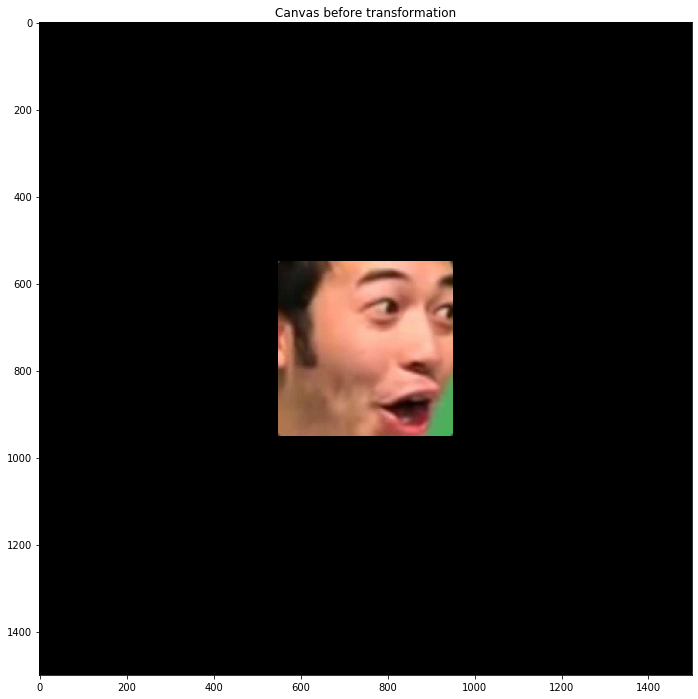

In [4]:
# Define the canvas size. Canvas is basically our workbench, in cartesian
canv_y, canv_x = 1500, 1500

canvas = np.zeros((canv_y,canv_x,3),dtype='uint8') # Instantinate the blank canvas

# Load the image we're going to use
impath = 'img/pog_400x400.jpg'
im = Image.open(impath)
im_arr = np.array(im)

# Defining source image metadata relative in canvas
im_ys, im_xs, _ = im_arr.shape # Image width and height
im_yo, im_xo = (canv_y-im_ys)//2, (canv_x-im_xs)//2 # anchor position in cartesian map

def aug_point_vec(x, y):
    """
    Augments a simple 2-dimensional point
    """
    return np.array([x, y, 1])

# Arrays of original corners of the source image relative in canvas
# bottom-left, and bottom-right, top-left, top-right, in cartesian
p_orig = [
    aug_point_vec(im_xo,im_yo),
    aug_point_vec(im_xo+im_xs,im_yo),
    aug_point_vec(im_xo,im_yo+im_ys),
    aug_point_vec(im_xo+im_xs,im_yo+im_ys),
]

# Creates initial canvas with original image
canvas_orig = canvas.copy()
canvas_orig[im_yo:im_ys+im_yo,im_xo:im_xs+im_xo] += np.flip(im_arr,0)
canvas_orig_print = np.flip(canvas_orig,0)
# As you probably notice, the source image is flipped. This is to compensate
# our operations that will be done not using cartesian map, because we will
# operate in the way computer array maps. The only difference is the direction
# of Y axis: cartesian map goes up, and the computer does the other. We're
# Basically converting source image mapped in cartesian to the computer mapping.
# Also notice the preview copy of the canvas (canvas_orig_print) is flipped
# again, to re-convert from computer mapping to cartesian mapping in preview.

# tl;dr, we're doing all operations in computer mapping instead of cartesian,
# but we made it to do operations as if it is doing it in cartesian map.

# Prints and saves the initial canvas
plt.imshow(canvas_orig_print)
plt.title('Canvas before transformation')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_orig.png")
plt.show()

Since translation, scaling, and rotation shares the same matrix and can be comined forming affine matrix, i will make a function that can generate translation, scaling, rotation, or any matrix with any combination of any of those three. Not giving any inputs to function will result in producing identity matrix, which will do nothing to resulting image.

In [5]:
def affine_3x3(tx=0, ty=0, s=1, theta=0, t=None, rot_mat=None):
    """
    Creates the affine matrix. Works for translation, scale, rotation,
    or any combinations out of it, even nothing at all (which basically)
    only creates an identity array.
    """
    out = np.identity(3) # Creates the I3 array as template
    if not t: # translation vector is not given
        t = np.array([tx,ty]) # use tx and ty to create one
    if not rot_mat: # scale & rotation matrix is not given
        rot_mat = np.array([ 
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])*s #create one instead using s and theta
    out[:2,2] = t # Applies the translation vector to the template
    out[:2,:2] = rot_mat # Applies the scale & rotation matrix to the template
    return out

For projection matrix, we have to solve for 8 unknowns in H transformation matrix. Solving them will require of finding the least squares of Ah=B, where h is the vector of 8 unknowns. Solving them computationally will require some more extensive linear algebra. Therefore, i took a better solution for calculating it computationally as [referred on some Math Stackexchange thread](https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog)

I'm using the second answer on the thread, as I don't like the effort of implementing linear algebra because it's not really worth the time and I only got 6 days left to do the second assignment and I'm already intimidated to that fact. Since we're solving for `h` in the equation `Ah=B`, I think it's wise to just move `A` to the right side of equation by inversing it first and follow the rules, so we have `h=A'B` in the end. Solving that requires us to define at least 4 pair of origin-target points, and I will use every corner of source image as the 4 origin points, and will later decide on the 4 target points so they will have 4 pairs of them.

I made three functions to accomodate that.

`expand_p_to_mat` will expand a pair of origin-target point into a 2x9 matrix that will be stacked together in the next function.

`stack_p` will stack all expanded pairs of origin-target points and will take the role of `A` variable in the equation.

`projection_3x3` is similar with `affine_3x3`, but will produce projective matrix instead based on the given pairs of origin-target points.

In [29]:
def expand_p_to_mat(p_or, p_tg):
    """
    Projective transformation H matrix helper
    
    Expands a pair of origin and target point in projection
    into a 2x9 matrix for the next calculation.
    """
    x_or, y_or, _ = p_or.T
    x_tg, y_tg, _ = p_tg.T
    return np.array([
        [-x_or, -y_or, -1, 0, 0, 0, x_or*x_tg, y_or*x_tg, x_tg],
        [0, 0, 0, -x_or, -y_or, -1, x_or*y_tg, y_or*y_tg, y_tg]
    ])

def stack_p(p_or_arr, p_tg_arr):
    """
    Projective transformation H matrix helper
    
    Stacks the expanded points into an array. If there is an
    n pair of points, the resulting array will be (n*2+1, 9)
    in size. Although, the expected points is 4 and resulting
    array is (9,9). So, please, i beg you.
    
    p_or_arr and p_tg_arr is arrays of respectively origin and
    target augmented points.
    """
    n = len(p_or_arr)
    out = np.zeros(((2*n)+1, 9))
    for i in range(n):
        out[i*2:i*2+2,:] = expand_p_to_mat(p_or_arr[i],p_tg_arr[i])
    out[-1,-1]=1
    return out

def projection_3x3(p_target, p_orig=p_orig):
    """
    Creates H matrix helper from given target augmented points
    array. You don't have to input the origin points because
    it is set to the previously set origin points array, but
    you can put it with other set of points.
    """
    P = stack_p(p_orig, p_target)
    h = np.zeros(9)
    h[-1]=1
    # Basically we need to solve Ah = b for h
    # but i hate to do SVD so we'll just move
    # A to the right side of equation so we have
    # h = A'b. That is the same reason why i use
    # a 9x9 A matrix and 9-vector b.
    return (np.linalg.inv(P) @ h.T).reshape(3,3)

It is possible to have the resulting coordinates beyond the limits of canvas, which are

- `x<0`
- `y<0`
- `x>=canvas_x_size`
- `y>=canvas_y_size`

Therefore, will make lambda functions that we can later use to handle that. The names of these methods are reflected on their key string. For some exceptions, I will divide some methods that handles x and y axis separately, just in case i set the canvas size to other non-uniform size:

In [16]:
clip_meth = {
    'as-is': lambda x:x,
    'dump_to_0,0_if_exceeding_limits_x': lambda x:x if x>=0 and x<canv_x else 0,
    'dump_to_0,0_if_exceeding_limits_y': lambda y:y if y>=0 and y<canv_y else 0,
    'modulo_out_of_limits_x': lambda x:x%canv_x,
    'modulo_out_of_limits_y': lambda y:y%canv_y
}

I've previously said that I will decide the target points for the origin-target pair later, and now is that moment. These are dynamic presets that will change based on the size of canvas. Notice that I also include a profile I named `undefined_projection` to try things that is _theoretically impossible_ that will be elaborated on the "interesting things I found during experimentation".

In [17]:
#projection profiles in cartesian to be used as target points
proj_prof = {
    'look_up': [ # Projects the image as if it is facing upwards, slanted.
        np.array([(canv_x*4)//15,(canv_y*4)//15,1]), np.array([canv_x-((canv_x*4)//15),(canv_y*4)//15,1]),
        np.array([(canv_x*6)//15,canv_y-((canv_y*4)//15),1]), np.array([canv_x-((canv_x*6)//15),canv_y-((canv_y*4)//15),1])
    ],
    'diamond_shard_to_top_right': [
        np.array([(canv_x*5)//15,(canv_y*5)//15,1]), np.array([canv_x-((canv_x*6)//15),(canv_y*4)//15,1]),
        np.array([(canv_x*4)//15,canv_y-((canv_y*6)//15),1]), np.array([canv_x-(canv_x//15),canv_y-(canv_y//15),1])
    ],
    'diamond_shard_to_bottom_right': [
        np.array([(canv_x*4)//15,(canv_y*6)//15,1]), np.array([canv_x-(canv_x//15),canv_y//15,1]),
        np.array([(canv_x*5)//15,canv_y-((canv_y*5)//15),1]), np.array([canv_x-((canv_x*6)//15),canv_y-((canv_y*4)//15),1])
    ],
    'undefined_projection': [
        p_orig[0],p_orig[1],p_orig[2],np.array([
            p_orig[0][0]+(p_orig[1][0]-p_orig[0][0])//4,p_orig[0][1]+(p_orig[2][1]-p_orig[0][1])//4,1
        ])
    ]
}

Below, these are functions that will handle the transformations as simple as providing the transformation matrix to the function. But before I make that function, I decided to create hitbox concept. After transformations, sometimes the object transformed will shape differently, so it is no longer a square assuming the initial shape is a square. Therefore, I will create a bounding box and generate all necessary points that will be transformed from the given origin points.

`get_hitbox_points` is a function that will generate all x-y pairs that represents all points in the hitbox, and ready to be used in the next function. This is a failsafe just in case the origin points isn't rectangle in shape.

`transform` will do as what the name refers to. Just give them the transformation matrix, and the function will do the rest. But if you want to bother to see how it works, here are the snippet:

In [24]:
def get_hitbox_points(p): #in cartesian
    """
    Creates a bounding box for points given surrounding all
    points. Then, within the bounding box, it generates all
    integral coordinates of each points bounded in it.
    """
    orig_x = list(x[0] for x in p)
    orig_y = list(x[1] for x in p)
    leftmost = np.min(orig_x)
    rightmost = np.max(orig_x)
    bottommost = np.min(orig_y)
    topmost = np.max(orig_y)
    x_p = range(leftmost,rightmost)
    y_p = range(bottommost,topmost)
    return np.array(list(itertools.product(x_p, y_p, list([1 for _ in range(len(orig_x)*len(orig_y))]))))

def transform(trans_arr, p_orig=p_orig, or_points=None,
              clipping_method=None,
              clipping_method_x=lambda x:x, clipping_method_y=lambda x:x,
              canvas_orig=canvas_orig, canvas_src=canvas,
              #verbose=False
             ):
    """
    Does the transformation IN THE COMPUTER ARRAY MAPPING WAY, NOT CARTESIAN. if
    you want to operate in cartesian, first flip the canvas_orig on the first axis
    before passing, and don't forget to get to flip the output before viewing.
    
    
    trans_arr
        the transformation matrix, make it 3x3.    
    p_orig
        array of augmented origin points.
    or_points
        the hitbox points made out of p_orig if you want to define one manually.
    clipping_method
        a function that handles the out of bounds array when moving pixel from origin
        to target. The target coordinate may exceed the limit either to negative
        or beyond maximum width/height of array. The default one is "let it be as-is,
        i'm confident there will no out of bounds exception because i have bachelor
        degree in computer science and you cannot say i should be ashamed for it."
    canvas_orig
        the initial state of canvas
    canvas_stc
        the blank canvas
    """
    # Checks if origin hitbox point is given or not. If not, use
    # the origin points to create one
    if not or_points:
        or_points = get_hitbox_points(p_orig).astype(np.float)
    
    #creates target points array by shallow copying origin points
    tg_points = or_points.copy()
    for i, p in enumerate(tg_points):
        #operate each point
        tg_points[i] = trans_arr@p
    #divide each result point with its own w
    tg_points/=tg_points[:,2].reshape((tg_points.shape[0],1))
    
    if clipping_method:
        clipping_method_x, clipping_method_y = clipping_method, clipping_method
    
    out_canv = canvas_src.copy() #instantinate output canvas from blank canvas
    for ((or_x, or_y), (tg_x, tg_y)) in zip(or_points[:,:2].astype(int), tg_points[:,:2].astype(int)):
        #copy pixel data from origin position to target position
        out_canv[clipping_method_y(tg_y),clipping_method_x(tg_x)] = canvas_orig[or_y,or_x]
    return out_canv

This is the demo of translation

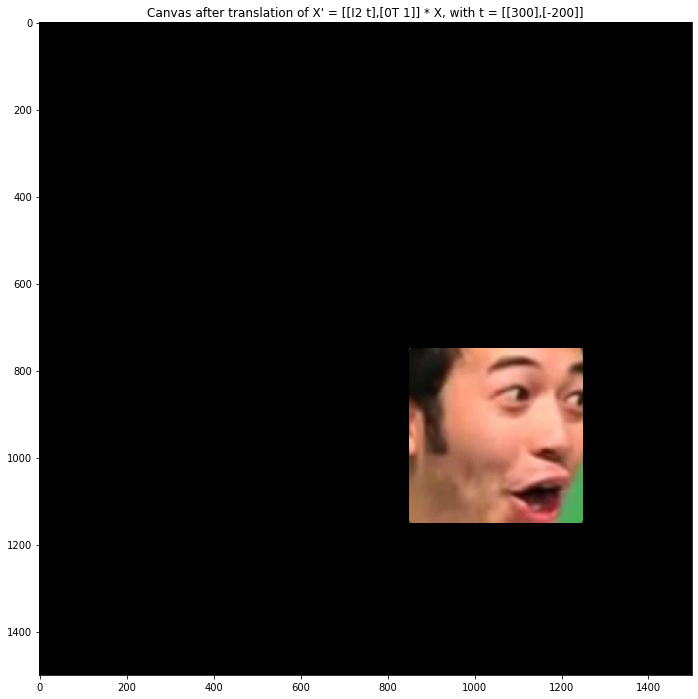

In [25]:
tx, ty = 300, -200
t_mat = affine_3x3(tx=tx,ty=ty)
canvas_t = transform(t_mat)
canvas_t_print = np.flip(canvas_t, 0)

plt.imshow(canvas_t_print)
plt.title(f'Canvas after translation of X\' = [[I2 t],[0T 1]] * X, with t = [[{tx}],[{ty}]]')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_t.png")
plt.show()

This is the demo of scaling

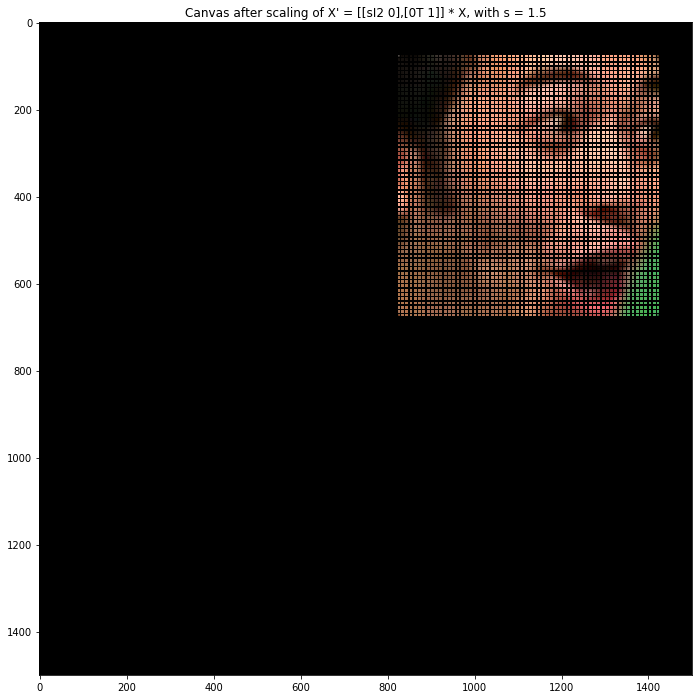

In [265]:
s = 1.5
s_mat = affine_3x3(s=s)
canvas_s = transform(s_mat)
canvas_s_print = np.flip(canvas_s, 0)

plt.imshow(canvas_s_print)
plt.title(f'Canvas after scaling of X\' = [[sI2 0],[0T 1]] * X, with s = {s}')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_s.png")
plt.show()

This is the demo of rotation

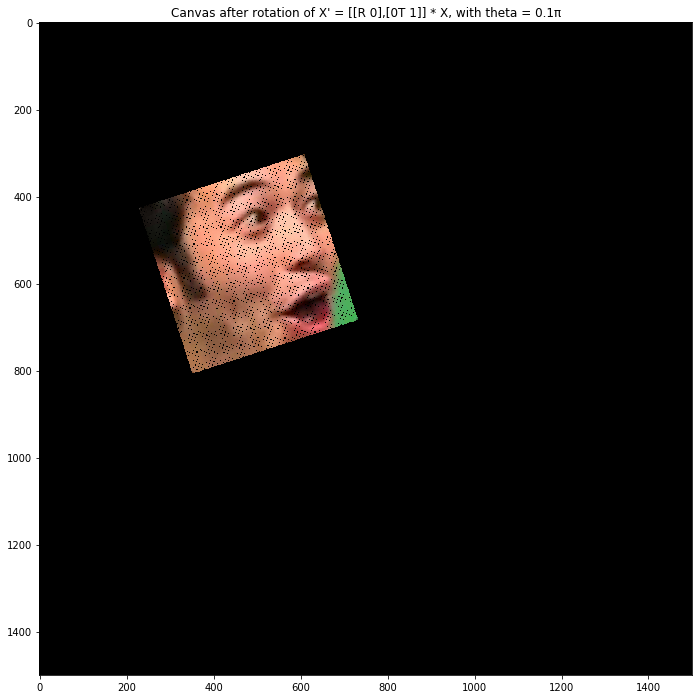

In [268]:
theta = np.pi*.1
r_mat = affine_3x3(theta=theta)
canvas_r = transform(r_mat)
canvas_r_print = np.flip(canvas_r, 0)

plt.imshow(canvas_r_print)
plt.title(f'Canvas after rotation of X\' = [[R 0],[0T 1]] * X, with theta = {r/np.pi}π')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_r.png")
plt.show()

This is the demo of affine transformation

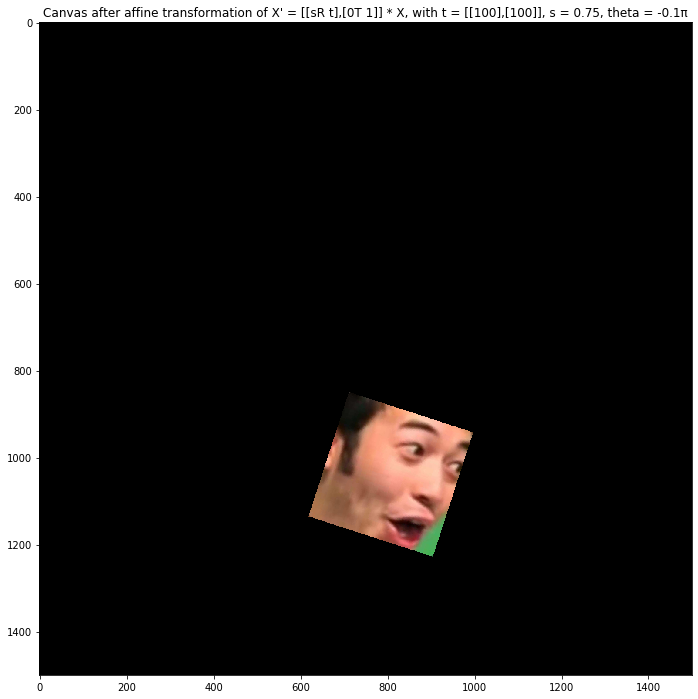

In [273]:
aff_s = .75
aff_theta = -np.pi*.1
aff_tx = 100
aff_ty = 100
aff_mat = affine_3x3(aff_tx, aff_ty, aff_s, aff_theta)
canvas_aff = transform(aff_mat)
canvas_aff_print = np.flip(canvas_aff, 0)

plt.imshow(canvas_aff_print)
plt.title(f'Canvas after affine transformation of X\' = [[sR t],[0T 1]] * X, with t = [[{aff_tx}],[{aff_ty}]], s = {aff_s}, theta = {aff_theta/np.pi}π')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_r.png")
plt.show()

This is the demo of projection

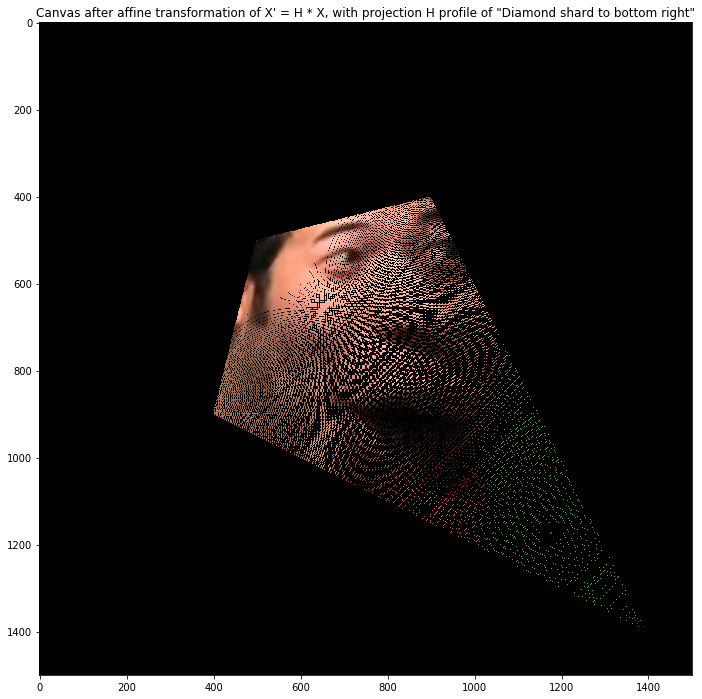

In [11]:
canvas_proj_dm_br = transform(projection_3x3(proj_prof['diamond_shard_to_bottom_right']))
canvas_proj_dm_br_print = np.flip(canvas_proj_dm_br, 0)

plt.imshow(canvas_proj_dm_br_print)
plt.title(f'Canvas after affine transformation of X\' = H * X, with projection H profile of "Diamond shard to bottom right"')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_proj_dm_br.png")
plt.show()

This is the interesting I found on this experiment. Theoretically. it is impossible to create a projections out of four points of target with one of them is inside a triangle made out of the rest of the three points, but I decided to try, So this is basically how it looks like:

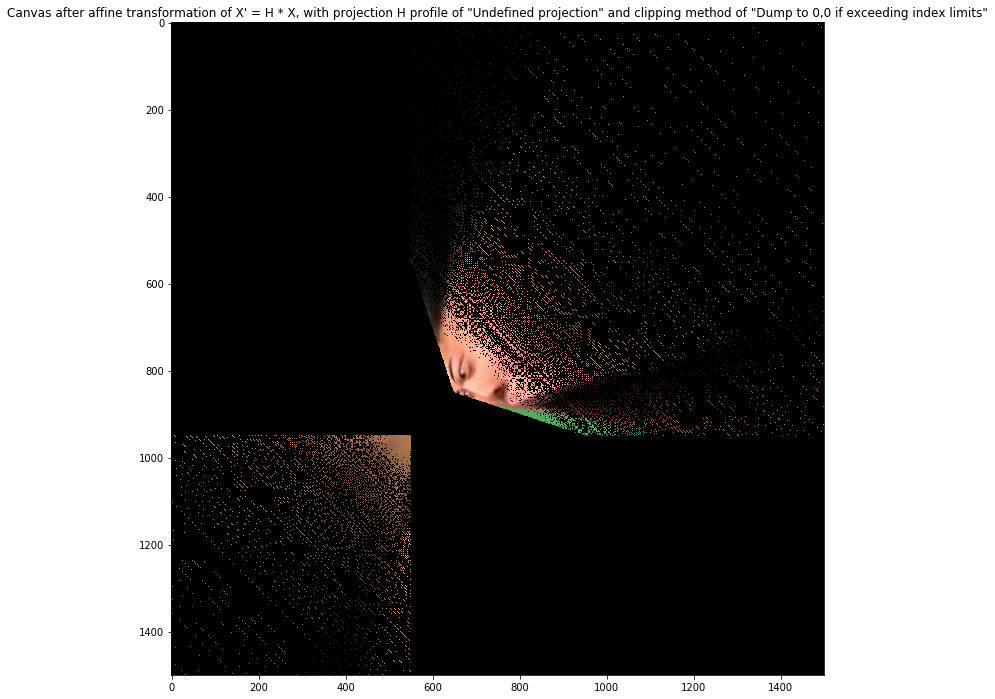

In [28]:
canvas_proj_undefined = transform(projection_3x3(proj_prof['undefined_projection']),
                             clipping_method_x=clip_meth['dump_to_0,0_if_exceeding_limits_x'],
                             clipping_method_y=clip_meth['dump_to_0,0_if_exceeding_limits_y'])
canvas_proj_undefined_print = np.flip(canvas_proj_undefined,0)

plt.imshow(canvas_proj_undefined_print)
plt.title(f'Canvas after affine transformation of X\' = H * X, with projection H profile of "Undefined projection" and clipping method of "Dump to 0,0 if exceeding index limits"')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_proj_undefined.png")
plt.show()